# Temperature

In [1]:
from scipy.io import netcdf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4
from sys import getsizeof
import numpy.ma as ma
import pickle as pkl

import os
import pandas as pd
from utils import *
import itertools
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
temp_file_path = './../Data/Temperature/nclimgrid_tavg.nc'

temp_nc_file = netCDF4.Dataset(temp_file_path, 'r')
print(temp_nc_file.variables)

{'time': <class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    long_name: Time, in monthly increments
    standard_name: time
    calendar: gregorian
    units: days since 1800-01-01 00:00:00
    axis: T
unlimited dimensions: time
current shape = (1546,)
filling on, default _FillValue of -2147483647 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
    valid_min: 24.562532
    valid_max: 49.3542
unlimited dimensions: 
current shape = (596,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lon': <class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
    valid_min: -124.6875
    valid_max: -67.020836
unlimited dimensions: 
current shape = (1385,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'tavg': <class 'netCDF4._netCDF4.Variable'>
float32 tavg(time, lat, lon)
  

In [3]:
t = temp_nc_file.variables['time']
time = t[:]
print(time.shape, type(time))
lon = temp_nc_file.variables['lon']
longitudes = lon[:]
print(longitudes.shape, type(longitudes))
lat = temp_nc_file.variables['lat']
latitudes = lat[:]
print(latitudes.shape, type(latitudes))
temperature_avg = temp_nc_file.variables['tavg']
tavg_original = temperature_avg[:]
print(tavg_original.shape, type(tavg_original))
skip_map = tavg_original.mask[-1]
print(skip_map.shape)

(1546,) <class 'numpy.ma.core.MaskedArray'>
(1385,) <class 'numpy.ma.core.MaskedArray'>
(596,) <class 'numpy.ma.core.MaskedArray'>
(1546, 596, 1385) <class 'numpy.ma.core.MaskedArray'>
(596, 1385)


In [11]:
new_lat = []
new_lon = []
downscale_factor = 9
downscale_offset = int(downscale_factor / 2)
for x in range(downscale_offset, len(lat), downscale_factor):
    new_lat.append(x)
for x in range(downscale_offset, len(lon), downscale_factor):
    new_lon.append(x)
print(latitudes[new_lat])
print(longitudes[new_lon])
print(len(new_lat), len(new_lon))
latlon_file = open('./final_datasets/Temperature/LatLon.pkl', 'wb')
pkl.dump([latitudes[new_lat], longitudes[new_lon]], latlon_file)
latlon_file.close()

[49.187534 48.812534 48.437534 48.062534 47.687534 47.312534 46.937534
 46.562534 46.187534 45.812534 45.437534 45.062534 44.687534 44.312534
 43.937534 43.562534 43.187534 42.812534 42.437534 42.062534 41.687534
 41.312534 40.937534 40.562534 40.187534 39.812534 39.437534 39.062534
 38.687534 38.312534 37.937534 37.562534 37.187534 36.812534 36.437534
 36.062534 35.687534 35.312534 34.937534 34.562534 34.187534 33.812534
 33.437534 33.062534 32.687534 32.312534 31.937532 31.562532 31.187532
 30.812532 30.437532 30.062532 29.687532 29.312532 28.937532 28.562532
 28.187532 27.812532 27.437532 27.062532 26.687532 26.312532 25.937532
 25.562532 25.187532 24.812532]
[-124.520836 -124.145836 -123.770836 -123.395836 -123.020836 -122.645836
 -122.270836 -121.895836 -121.520836 -121.145836 -120.770836 -120.395836
 -120.020836 -119.645836 -119.270836 -118.895836 -118.520836 -118.145836
 -117.770836 -117.395836 -117.020836 -116.645836 -116.270836 -115.895836
 -115.520836 -115.145836 -114.770836 

In [20]:
# downscale the grid
new_lat = []
new_lon = []
new_tavg = []
new_mask = []
full_res = []
down_res = []
downscale_factor = 9
downscale_offset = int(downscale_factor / 2)
for t in range(len(tavg_original)):
    print("TIMESTEP: " + str(t))
    time_step = []
    mask_step = []
    full_res.append(tavg_original[t])
    for x in range(downscale_offset, len(tavg_original[0]), downscale_factor):
        row = []
        mask_row = []
        for y in range(downscale_offset, len(tavg_original[0][0]), downscale_factor):
            row.append(tavg_original[t][x][y])
            mask_row.append(tavg_original.mask[t][x][y])
        time_step.append(row)
        mask_step.append(mask_row)
    down_res.append(time_step)
    new_tavg.append(time_step)
    new_mask.append(mask_step)
new_mask = np.array(new_mask)
skip_map = new_mask[-1]
print(np.array(new_tavg).shape)
print(new_mask.shape)
for x in range(downscale_offset, len(lat), downscale_factor):
    new_lat.append(x)
for x in range(downscale_offset, len(lon), downscale_factor):
    new_lon.append(x)

TIMESTEP: 0
TIMESTEP: 1
TIMESTEP: 2
TIMESTEP: 3
TIMESTEP: 4
TIMESTEP: 5
TIMESTEP: 6
TIMESTEP: 7
TIMESTEP: 8
TIMESTEP: 9
TIMESTEP: 10
TIMESTEP: 11
TIMESTEP: 12
TIMESTEP: 13
TIMESTEP: 14
TIMESTEP: 15
TIMESTEP: 16
TIMESTEP: 17
TIMESTEP: 18
TIMESTEP: 19
TIMESTEP: 20
TIMESTEP: 21
TIMESTEP: 22
TIMESTEP: 23
TIMESTEP: 24
TIMESTEP: 25
TIMESTEP: 26
TIMESTEP: 27
TIMESTEP: 28
TIMESTEP: 29
TIMESTEP: 30
TIMESTEP: 31
TIMESTEP: 32
TIMESTEP: 33
TIMESTEP: 34
TIMESTEP: 35
TIMESTEP: 36
TIMESTEP: 37
TIMESTEP: 38
TIMESTEP: 39
TIMESTEP: 40
TIMESTEP: 41
TIMESTEP: 42
TIMESTEP: 43
TIMESTEP: 44
TIMESTEP: 45
TIMESTEP: 46
TIMESTEP: 47
TIMESTEP: 48
TIMESTEP: 49
TIMESTEP: 50
TIMESTEP: 51
TIMESTEP: 52
TIMESTEP: 53
TIMESTEP: 54
TIMESTEP: 55
TIMESTEP: 56
TIMESTEP: 57
TIMESTEP: 58
TIMESTEP: 59
TIMESTEP: 60
TIMESTEP: 61
TIMESTEP: 62
TIMESTEP: 63
TIMESTEP: 64
TIMESTEP: 65
TIMESTEP: 66
TIMESTEP: 67
TIMESTEP: 68
TIMESTEP: 69
TIMESTEP: 70
TIMESTEP: 71
TIMESTEP: 72
TIMESTEP: 73
TIMESTEP: 74
TIMESTEP: 75
TIMESTEP: 76
TIMESTEP:

C:\Users\Astro\AppData\Local\Temp\ipykernel_26688\382595084.py:28: UserWarning: Warning: converting a masked element to nan.
  print(np.array(new_tavg).shape)


(1546, 66, 154)
(1546, 66, 154)


In [21]:
new_lat  = np.array(new_lat)
new_lon  = np.array(new_lon)
new_tavg = ma.masked_array(new_tavg, mask=new_mask)
print(new_lat.shape, new_lon.shape, new_tavg.shape)
# comment out to allow higher resolution
tavg = new_tavg

c:\Python311\Lib\site-packages\numpy\ma\core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


(66,) (154,) (1546, 66, 154)


In [22]:
fill_value = -30.
tavg[tavg.mask] = fill_value
tavg_np = np.array(tavg)
mean = np.mean(tavg_np)
std = np.std(tavg_np)
print(mean, std)
tavg_np = (tavg_np - mean) / std
n_lat = len(tavg_np[0])
n_lon = len(tavg_np[0][0])
print(n_lat, n_lon)

-6.645582311142401 21.709711650323637
66 154


(66, 154)


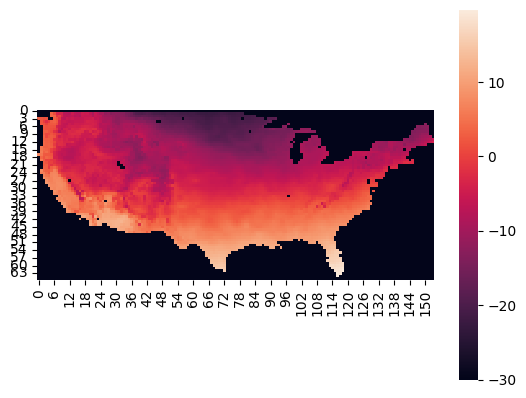

In [23]:
ax = sns.heatmap(tavg[0], square=True)
# ax = sns.heatmap(tavg_np[0] * std + mean, vmin=-30, vmax=40, square=True)
print(tavg[-1].shape)

In [24]:
year_start = 1950
data_shortened = tavg[12*(year_start-1895):]
print(data_shortened.shape)

(886, 66, 154)


## Building the Model

In [25]:
window          = 24
#                      16
n_feature       = 1
n_filters       = 8 # number of filters
kernel_size     = 16  # kernel size for Covolutional layers
pool_size       = 4  # size for average pooling layers
activation      = 'relu'  # activation function
n_lstm_unit     = 24 # number of LSTM units
learning_rate   = 1e-4 # learning rate
minibatch_size  = 64   # batch size
num_epochs = 50
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [26]:
print(data_shortened.shape)

(886, 66, 154)


In [27]:
window = 24
X = []
Y = []
std = np.std(data_shortened)
mean = np.mean(data_shortened)
for i in range(len(data_shortened) - window - 1):
    X.append(data_shortened[i:i+24])
    Y.append(data_shortened[i+24])
X = (np.array(X) - mean) / std
Y = (np.array(Y) - mean) / std
data_standardized = (np.array(data_shortened) - mean) / std
print(X.shape, Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(861, 24, 66, 154) (861, 66, 154)
(688, 24, 66, 154) (173, 24, 66, 154) (688, 66, 154) (173, 66, 154)


In [28]:
# model_mse = Sequential()
# model_mse.add(Input(shape=(window, n_lat,n_lon,n_feature)))
# model_mse.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
#                                     padding='same', activation=activation), input_shape=(window, n_lat,n_lon,n_feature)))
# model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
# model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
# model_mse.add(LSTM(n_lstm_unit, activation=activation))
# model_mse.add(Dense(n_lat*n_lon))
# model_mse.add(Activation('linear'))
# model_mse.add(Reshape((1, n_lat,n_lon)))


# model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

# model   = model_mse
# history = model.fit(X_train, y_train, 
#                     batch_size = minibatch_size,
#                     epochs = num_epochs,
#                     validation_split=0.2, verbose=1,
#                     callbacks=[early_stop])

## Projecting to find 2030

In [30]:
# # Prepare the data to predict forward
# year_start_new = 2020
# data_predict_basis = data_standardized[(year_start_new - year_start) * 12:(year_start_new - year_start + 2) * 12]
# print(data_predict_basis.shape)

# def predict_forward(model, data, years):
#     data_list = list(data)
#     for i in range(12 * years):
#         print("MONTH ", i % 12, " YEAR ", 2020+(i // 12))
#         reshaped = np.reshape(data_list[-24:], (1,window,n_lat,n_lon))
#         print(reshaped.shape)
#         next_month = model.predict(reshaped)
#         print(next_month[0][0].shape)
#         data_list.append(next_month[0][0])
#         print(np.array(data_list).shape)
#     return data_list

# pred_2030 = predict_forward(model, data_predict_basis, 10)

In [31]:
print(tavg.shape)
file_names = []
n_years = tavg.shape[0] // 12
for i in range(tavg.shape[0] // 12):
    print(str(i + 1) + '/' + str(n_years))
    ax = sns.heatmap(tavg[i * 12], vmin=-30, vmax=30, square=True)
    # year = 2020 + int(i / 12)
    # month = i % 12
    # ax.set_title(month_names[month] + ". " + str(year))
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    fig = ax.get_figure()
    file_name = "./figures/temperature_temp/" + str(i) + "_temp.png"
    fig.savefig(file_name)
    file_names.append(file_name)
    fig.clear()
    ax.clear()
    
# Gather all PNG files in the current directory
images = [Image.open(file) for file in file_names]

# Set the duration for each frame in milliseconds
duration = 100

# Save the images as a GIF animation
images[0].save('./figures/TemperatureProjection_Jan.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

(1546, 66, 154)
1/128
2/128
3/128
4/128
5/128
6/128
7/128
8/128
9/128
10/128
11/128
12/128
13/128
14/128
15/128
16/128
17/128
18/128
19/128
20/128
21/128
22/128
23/128
24/128
25/128
26/128
27/128
28/128
29/128
30/128
31/128
32/128
33/128
34/128
35/128
36/128
37/128
38/128
39/128
40/128
41/128
42/128
43/128
44/128
45/128
46/128
47/128
48/128
49/128
50/128
51/128
52/128
53/128
54/128
55/128
56/128
57/128
58/128
59/128
60/128
61/128
62/128
63/128
64/128
65/128
66/128
67/128
68/128
69/128
70/128
71/128
72/128
73/128
74/128
75/128
76/128
77/128
78/128
79/128
80/128
81/128
82/128
83/128
84/128
85/128
86/128
87/128
88/128
89/128
90/128
91/128
92/128
93/128
94/128
95/128
96/128
97/128
98/128
99/128
100/128
101/128
102/128
103/128
104/128
105/128
106/128
107/128
108/128
109/128
110/128
111/128
112/128
113/128
114/128
115/128
116/128
117/128
118/128
119/128
120/128
121/128
122/128
123/128
124/128
125/128
126/128
127/128
128/128


NameError: name 'Image' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# n_months = len(pred_2030)
# min_val = min(np.array(pred_2030).flatten())
# max_val = max(np.array(pred_2030).flatten())
# file_names = []
# for i in range(n_months):
#     print(str(i) + '/' + str(n_months))
#     ax = sns.heatmap(pred_2030[i], vmin=min_val, vmax=max_val, square=True)
#     year = 2020 + int(i / 12)
#     month = i % 12
#     ax.set_title(month_names[month] + ". " + str(year))
#     ax.set(xticklabels=[], yticklabels=[])
#     ax.tick_params(bottom=False, left=False)
#     fig = ax.get_figure()
#     file_name = "./figures/temperature_temp/" + str(i) + "_temp.png"
#     fig.savefig(file_name)
#     file_names.append(file_name)
#     fig.clear()
#     ax.clear()
    
# # Gather all PNG files in the current directory
# images = [Image.open(file) for file in file_names]

# # Set the duration for each frame in milliseconds
# duration = 100

# # Save the images as a GIF animation
# images[0].save('./final_figures/TemperatureSubgridProjection.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

0/144
1/144
2/144
3/144
4/144
5/144
6/144
7/144
8/144
9/144
10/144
11/144
12/144
13/144
14/144
15/144
16/144
17/144
18/144
19/144
20/144
21/144
22/144
23/144
24/144
25/144
26/144
27/144
28/144
29/144
30/144
31/144
32/144
33/144
34/144
35/144
36/144
37/144
38/144
39/144
40/144
41/144
42/144
43/144
44/144
45/144
46/144
47/144
48/144
49/144
50/144
51/144
52/144
53/144
54/144
55/144
56/144
57/144
58/144
59/144
60/144
61/144
62/144
63/144
64/144
65/144
66/144
67/144
68/144
69/144
70/144
71/144
72/144
73/144
74/144
75/144
76/144
77/144
78/144
79/144
80/144
81/144
82/144
83/144
84/144
85/144
86/144
87/144
88/144
89/144
90/144
91/144
92/144
93/144
94/144
95/144
96/144
97/144
98/144
99/144
100/144
101/144
102/144
103/144
104/144
105/144
106/144
107/144
108/144
109/144
110/144
111/144
112/144
113/144
114/144
115/144
116/144
117/144
118/144
119/144
120/144
121/144
122/144
123/144
124/144
125/144
126/144
127/144
128/144
129/144
130/144
131/144
132/144
133/144
134/144
135/144
136/144
137/144
138/14

<Figure size 640x480 with 0 Axes>

Model predicts the same month no matter the input. We change approach

## Yearly min, max, avg temperature:

In [34]:
n_years = len(tavg_np)
n_lat = len(tavg_np[0])
n_lon = len(tavg_np[0][0])
yearly_avg = []
yearly_min = []
yearly_max = []
print(tavg_np.shape, n_lat, n_lon)
for t in range(n_years // 12):
    print("YEAR", 1895 + t)
    avg_year = []
    min_year = []
    max_year = []
    for y in range(n_lat):
        avg_row = []
        min_row = []
        max_row = []
        for x in range(n_lon):
            isolated_year = tavg_np[t*12:(t+1)*12,y,x]
            avg_row.append(np.median(isolated_year))
            min_row.append(min(isolated_year))
            max_row.append(max(isolated_year))
        avg_year.append(avg_row)
        min_year.append(min_row)
        max_year.append(max_row)
    yearly_avg.append(avg_year)
    yearly_min.append(min_year)
    yearly_max.append(max_year)
yearly_avg = np.array(yearly_avg)
yearly_min = np.array(yearly_min)
yearly_max = np.array(yearly_max)
print(yearly_avg.shape, yearly_min.shape, yearly_max.shape)
yearly_data = [yearly_avg, yearly_min, yearly_max]

(1546, 66, 154) 66 154
YEAR 1895
YEAR 1896
YEAR 1897
YEAR 1898
YEAR 1899
YEAR 1900
YEAR 1901
YEAR 1902
YEAR 1903
YEAR 1904
YEAR 1905
YEAR 1906
YEAR 1907
YEAR 1908
YEAR 1909
YEAR 1910
YEAR 1911
YEAR 1912
YEAR 1913
YEAR 1914
YEAR 1915
YEAR 1916
YEAR 1917
YEAR 1918
YEAR 1919
YEAR 1920
YEAR 1921
YEAR 1922
YEAR 1923
YEAR 1924
YEAR 1925
YEAR 1926
YEAR 1927
YEAR 1928
YEAR 1929
YEAR 1930
YEAR 1931
YEAR 1932
YEAR 1933
YEAR 1934
YEAR 1935
YEAR 1936
YEAR 1937
YEAR 1938
YEAR 1939
YEAR 1940
YEAR 1941
YEAR 1942
YEAR 1943
YEAR 1944
YEAR 1945
YEAR 1946
YEAR 1947
YEAR 1948
YEAR 1949
YEAR 1950
YEAR 1951
YEAR 1952
YEAR 1953
YEAR 1954
YEAR 1955
YEAR 1956
YEAR 1957
YEAR 1958
YEAR 1959
YEAR 1960
YEAR 1961
YEAR 1962
YEAR 1963
YEAR 1964
YEAR 1965
YEAR 1966
YEAR 1967
YEAR 1968
YEAR 1969
YEAR 1970
YEAR 1971
YEAR 1972
YEAR 1973
YEAR 1974
YEAR 1975
YEAR 1976
YEAR 1977
YEAR 1978
YEAR 1979
YEAR 1980
YEAR 1981
YEAR 1982
YEAR 1983
YEAR 1984
YEAR 1985
YEAR 1986
YEAR 1987
YEAR 1988
YEAR 1989
YEAR 1990
YEAR 1991
YEAR 19

In [35]:
# standardize datasets
stdevs = [np.std(x) for x in yearly_data]
means  = [np.mean(x) for x in yearly_data]
norm_data = [(yearly_data[i] - means[i]) / stdevs[i] for i in range(3)]
print(stdevs, means)

[0.9560223391028143, 0.6811000987791257, 1.22348067987687] [0.00596973506742244, -0.35231193594429855, 0.3246316947142005]


Determining best hyperparameters for the yearly median temperature case

In [36]:
def build_test_model(params, data):
    window = params['window']
    n_lon = params['n_lon']
    n_lat = params['n_lat']
    n_feature = params['n_feature']
    n_filters = params['n_filters']
    kernel_size = params['kernel_size']
    activation = params['activation']
    pool_size = params['pool_size']
    n_lstm_unit = params['n_lstm_unit']
    learning_rate = params['learning_rate']
    minibatch_size = params['minibatch_size']
    num_epochs = params['num_epochs']
    patience_val = params['patience_val']
    
    X = []
    Y = []
    for i in range(len(data) - window - 1):
        X.append(data[i:i+window,:,])
        Y.append(data[i+window,:,])

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_val)

    model_CNN_LSTM = Sequential()
    model_CNN_LSTM.add(Input(shape=(window, n_lat,n_lon,n_feature), name='input'))
    model_CNN_LSTM.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                        padding='same', activation=activation), input_shape=(window, n_lat,n_lon,n_feature), name='conv2d'))
    model_CNN_LSTM.add(TimeDistributed(AveragePooling2D(pool_size), name='ave_pool'))
    model_CNN_LSTM.add(TimeDistributed(GlobalAveragePooling2D(), name='global_pool'))
    model_CNN_LSTM.add(LSTM(n_lstm_unit, activation=activation, name='lstm'))
    model_CNN_LSTM.add(Dense(n_lat*n_lon, name='dense'))
    model_CNN_LSTM.add(Activation('linear', name='activation'))
    model_CNN_LSTM.add(Reshape((1, n_lat,n_lon), name='reshape'))

    model_CNN_LSTM.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    history = model_CNN_LSTM.fit(np.array(X), np.array(Y), 
                        batch_size = minibatch_size,
                        epochs = num_epochs,
                        validation_split=0.2, verbose=0,
                        callbacks=[early_stop])
    
    return model_CNN_LSTM, history

In [37]:
window_arr          = [4, 8, 16]
n_feature_arr       = [1]
n_filters_arr       = [4, 8, 16] # number of filters
kernel_size_arr     = [4, 8, 16]  # kernel size for Covolutional layers
pool_size_arr       = [8, 16, 32]  # size for average pooling layers
activation_arr      = ['relu']  # activation function
n_lstm_unit_arr     = [8, 16, 32] # number of LSTM units
learning_rate_arr   = [1e-3, 5e-4] # learning rate
minibatch_size_arr  = [8, 32]   # batch size
num_epochs_arr = [50]
patience_arr = [5]
param_arr = [window_arr, n_feature_arr, n_filters_arr, kernel_size_arr,
             pool_size_arr, activation_arr, n_lstm_unit_arr, learning_rate_arr,
             minibatch_size_arr, num_epochs_arr, patience_arr]

param_list = list(itertools.product(*param_arr))
print(len(param_list))

972


In [38]:
# loss_list = []
# i = 0

# for param_set in param_list:
#     print("PARAM SET " + str(i + 1) + "/" + str(len(param_list)) + " " + str(param_set))
#     params = {}
#     params['window']            = param_set[0]
#     params['n_lon']             = n_lon
#     params['n_lat']             = n_lat
#     params['n_feature']         = param_set[1]
#     params['n_filters']         = param_set[2]
#     params['kernel_size']       = param_set[3]
#     params['pool_size']         = param_set[4]
#     params['activation']        = param_set[5]
#     params['n_lstm_unit']       = param_set[6]
#     params['learning_rate']     = param_set[7]
#     params['minibatch_size']    = param_set[8]
#     params['num_epochs']        = param_set[9]
#     params['patience_val']      = param_set[10]
#     model, history = build_test_model(params, yearly_data[0])
#     training_loss   = history.history['loss']
#     validation_loss = history.history['val_loss']
#     loss_list.append(validation_loss[-1])
#     print("MSE Train Loss:\t", str(training_loss[-1]))
#     print("MSE Valid Loss:\t", str(validation_loss[-1]))
#     i += 1

In [39]:
file_params = open('./local_storage/temp_avg_search_1.pkl', 'wb')
pkl.dump([param_set, loss_list], file_params)
file_params.close()

NameError: name 'param_set' is not defined

In [40]:
loss_list_param = [(param_list[i], loss_list[i]) for i in range(len(param_list))]
sorted_loss_list_param = sorted(loss_list_param, key=lambda x: x[1])
for i in range(10):
    print(sorted_loss_list_param[i])

NameError: name 'loss_list' is not defined

In [41]:
X = []
Y = []
for i in range(len(yearly_data[0]) - window - 1):
    X.append(yearly_data[0][i:i+window,:,])
    Y.append(yearly_data[0][i+window,:,])
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(type(X_train), type(y_train))

(82, 24, 66, 154) (21, 24, 66, 154) (82, 66, 154) (21, 66, 154)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [42]:
model_CNN_LSTM = Sequential()
model_CNN_LSTM.add(Input(shape=(window, n_lat,n_lon,n_feature), name='input'))
model_CNN_LSTM.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                    padding='same', activation=activation), input_shape=(window, n_lat,n_lon,n_feature), name='conv2d'))
model_CNN_LSTM.add(TimeDistributed(AveragePooling2D(pool_size), name='ave_pool'))
model_CNN_LSTM.add(TimeDistributed(GlobalAveragePooling2D(), name='global_pool'))
model_CNN_LSTM.add(LSTM(n_lstm_unit, activation=activation, name='lstm'))
model_CNN_LSTM.add(Dense(n_lat*n_lon, name='dense'))
model_CNN_LSTM.add(Activation('linear', name='activation'))
model_CNN_LSTM.add(Reshape((1, n_lat,n_lon), name='reshape'))

print(window, n_lat,n_lon,n_feature)
print(X_train.shape, y_train.shape)
model_CNN_LSTM.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

model   = model_CNN_LSTM
history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

24 66 154 1
(82, 24, 66, 154) (82, 66, 154)
Epoch 1/50

2/2 [==============================] - 3s 353ms/step - loss: 0.9190 - val_loss: 0.9150
Epoch 2/50
2/2 [==============================] - 1s 168ms/step - loss: 0.9184 - val_loss: 0.9144
Epoch 3/50
2/2 [==============================] - 1s 153ms/step - loss: 0.9178 - val_loss: 0.9138
Epoch 4/50
2/2 [==============================] - 1s 163ms/step - loss: 0.9172 - val_loss: 0.9131
Epoch 5/50
2/2 [==============================] - 1s 179ms/step - loss: 0.9165 - val_loss: 0.9124
Epoch 6/50
2/2 [==============================] - 1s 163ms/step - loss: 0.9158 - val_loss: 0.9116
Epoch 7/50
2/2 [==============================] - 1s 163ms/step - loss: 0.9150 - val_loss: 0.9108
Epoch 8/50
2/2 [==============================] - 1s 160ms/step - loss: 0.9142 - val_loss: 0.9099
Epoch 9/50
2/2 [==============================] - 1s 171ms/step - loss: 0.9133 - val_loss: 0.9089
Epoch 10/50
2/2 [==============================] - 1s 190ms/step - loss: 

In [43]:
model_path = './final_models/'

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(model_path + 'avg_temp_model.keras')

In [44]:
# (16, 1, 8, 8, 32, 'relu', 32, 0.001, 8, 50, 5)
window          = 16
n_feature       = 1
n_filters       = 8 # number of filters
kernel_size     = 8  # kernel size for Covolutional layers
pool_size       = 32  # size for average pooling layers
activation      = 'relu'  # activation function
n_lstm_unit     = 32 # number of LSTM units
learning_rate   = 1e-3 # learning rate
minibatch_size  = 8  # batch size
num_epochs      = 50
patience        = 10

In [45]:
final_params = {}
final_params['window']            = window
final_params['n_lon']             = n_lon
final_params['n_lat']             = n_lat
final_params['n_feature']         = n_feature
final_params['n_filters']         = n_filters
final_params['kernel_size']       = kernel_size
final_params['pool_size']         = pool_size
final_params['activation']        = activation
final_params['n_lstm_unit']       = n_lstm_unit
final_params['learning_rate']     = learning_rate
final_params['minibatch_size']    = minibatch_size
final_params['num_epochs']        = num_epochs
final_params['patience_val']      = patience

In [46]:
seperated_labels = ['YearlyAvg', 'YearlyMin', 'YearlyMax']
seperated_titles = ['Yearly Average Monthly Temperature', 'Yearly Minimum Monthly Temperature', 'Yearly Maximum Monthly Temperature']

In [47]:
def predict_forward(model, data, years):
    data_list = list(data)
    for i in range(years):
        reshaped = np.reshape(data_list[-window:], (1,window,n_lat,n_lon))
        next_month = model.predict(reshaped)
        data_list.append(next_month[0][0])
    return data_list

In [58]:
sns.set(rc={'figure.figsize':(13,6)})
# train, use, and save final models and temperature figures
final_models    = []
final_preds     = []
final_histories = []
for i in range(3):
    print("Training " + seperated_titles[i])
    print(stdevs[i], means[i])
    # train the model
    curr_model, curr_history = build_test_model(final_params, yearly_data[i])
    final_models.append(curr_model)
    final_histories.append(curr_history)
    print("Final losses:")
    print("\tTraining Loss:\t\t" + str(curr_history.history['loss'][-1]))
    print("\tValidation Loss:\t" + str(curr_history.history['val_loss'][-1]))

    # format data and project forward
    year_start = 2020
    prediction_data_start = yearly_data[i][year_start - 1895 - window:year_start - 1895]
    pred_2030 = predict_forward(curr_model, prediction_data_start, 2030 - year_start)
    final_preds.append((np.array(pred_2030) * stdevs[i] + means[i]) * std + mean)
    val_min = np.min(np.array(pred_2030).flatten())
    val_max = np.max(np.array(pred_2030).flatten())

    # create the gif
    file_names = []
    n_years = len(pred_2030)
    pred_2030 = (np.array(pred_2030) * stdevs[i] + means[i]) * std + mean
    val_min = min(pred_2030.flatten())
    val_max = max(pred_2030.flatten())
    for j in range(len(pred_2030)):
        ax = sns.heatmap(pred_2030[j], vmin=val_min, vmax=val_max, square=True)
        ax.set_title(seperated_titles[i] + ' - ' + str(2020 - window + j))
        ax.set(xticklabels=[], yticklabels=[])
        ax.tick_params(bottom=False, left=False)
        fig = ax.get_figure()
        file_name = "./figures/temperature_temp/" + str(j) + "_temp.png"
        fig.savefig(file_name, dpi=200, bbox_inches='tight')
        file_names.append(file_name)
        fig.clear()
        ax.clear()
        
    # Gather all PNG files in the current directory
    images = [Image.open(file) for file in file_names]

    # Set the duration for each frame in milliseconds
    duration = 100

    # Save the images as a GIF animation
    images[0].save('./final_figures/Temperature/TemperatureProjection_' + seperated_labels[i] + '.gif', save_all=True, append_images=images[1:], optimize=False, duration=duration, loop=0)

    # save the model
    model_path = './final_models/'
    model.save(model_path + seperated_labels[i] + '_model.keras')

    # save the projected data (2020-2030)
    file_params = open('./final_datasets/Temperature/temp_' + seperated_labels[i] + '.pkl', 'wb')
    pkl.dump(pred_2030[-10:], file_params)
    file_params.close()

Training Yearly Average Monthly Temperature
0.9560223391028143 0.00596973506742244
Final losses:
	Training Loss:		0.0018489229260012507
	Validation Loss:	0.0026817377656698227
1/1 [==============================] - 0s 15ms/step
Training Yearly Minimum Monthly Temperature
0.6811000987791257 -0.35231193594429855
Final losses:
	Training Loss:		0.007529845926910639
	Validation Loss:	0.007352909538894892
1/1 [==============================] - 0s 17ms/step
Training Yearly Maximum Monthly Temperature
1.22348067987687 0.3246316947142005
Final losses:
	Training Loss:		0.001649282407015562
	Validation Loss:	0.0020997729152441025
1/1 [==============================] - 0s 17ms/step


<Figure size 1300x600 with 0 Axes>

In [59]:
final_preds = np.array(final_preds)
print(final_preds.shape)
for i in range(3):
    val_min = np.min(np.array(final_preds[i][-1]).flatten())
    val_max = np.max(np.array(final_preds[i][-1]).flatten())
    ax = sns.heatmap(final_preds[i][-1], vmin=val_min, vmax=val_max, square=True)
    ax.set_title(seperated_titles[i] + ' 2030')
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    fig = ax.get_figure()
    file_name = "./final_figures/Temperature/" + seperated_labels[i] + "_2030.png"
    fig.savefig(file_name, dpi=200, bbox_inches='tight')
    file_names.append(file_name)
    fig.clear()
    ax.clear()

(3, 26, 66, 154)


<Figure size 1300x600 with 0 Axes>

In [1]:
# save latitude and longitude data
print(len(new_lat), len(new_lon))
final_lat = [latitudes[i] for i in new_lat]
final_lon = [longitudes[i] for i in new_lon]
print(len(final_lat), len(final_lon))
# save the latitudes and longitudes
file_params = open('./final_datasets/Temperature/LatLon.pkl', 'wb')
pkl.dump([final_lat, final_lon], file_params)
file_params.close()

NameError: name 'new_lat' is not defined